# MedFollow: Agentic Decision-Support for Medication Follow-Up

**BioFusion Hackathon 2026**

**Disclaimer**: This system is a prototype for clinical decision support. It does not provide medical advice, diagnoses, or prescriptions. All high-stakes decisions should be referred to a qualified healthcare professional.

## 1. Problem Definition

### Clinical Relevance
Adherence to medication and timely follow-up are critical for treatment success. deeply analyzing patient-reported outcomes (PROs) allows for early intervention in cases of ineffectiveness or severe side effects. This project aims to automate the triage process by analyzing unstructured patient reviews to predict medication effectiveness and recommend appropriate fit-for-purpose actions.

### Prediction Goal
The primary goal is to predict the **Effectiveness** of a medication based on patient reviews and metadata. The system subsequently utilizes this prediction, along with integrity and safety checks, to recommend a follow-up action (e.g., Continue, Monitor, or Urgent Consult).

In [31]:
# Environment Setup & Reproducibility
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output in the final report
warnings.filterwarnings('ignore')

# Set Global Seeds for Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

print(f"Global Random Seed set to: {SEED}")

Global Random Seed set to: 42


## 2. Dataset Documentation

### Citation
**Source**: UCI Machine Learning Repository - Drug Reviews (Druglib.com)
**License**: CC BY 4.0

### Variables Description
- **urlDrugName**: Name of the drug.
- **condition**: Condition the patient is reporting on.
- **benefitsReview**: Patient's description of benefits.
- **sideEffectsReview**: Patient's description of side effects.
- **commentsReview**: General comments.
- **rating**: Numerical rating (1-10).
- **sideEffects**: Self-reported side effect severity.
- **effectiveness**: Target categorical variable (Highly Effective, Marginally Effective, etc.).

In [32]:
# Data Loading
DATA_PATH = 'data/drug_reviews/data.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    # Fallback for online environment or if local path is missing
    print("Local dataset not found. Downloading from UCI source...")
    url = "https://archive.ics.uci.edu/static/public/461/data.csv"
    df = pd.read_csv(url)
    # Ensure directory exists before saving
    os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
    df.to_csv(DATA_PATH, index=False)
    print(f"Dataset downloaded and saved. Shape: {df.shape}")

# Display first few rows
df.head()

Dataset loaded successfully. Shape: (4143, 9)


,reviewID,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


### Preprocessing Steps
1.  **Missing Value Handling**: Drop rows where critical text fields or the target ('effectiveness') are missing.
2.  **Target Encoding**: Map the verbose 'effectiveness' labels to a simplified schema, then encode numerically.
3.  **Text Cleaning**: Lowercase, remove special characters, and handle nulls in text columns.

In [33]:
# Data Cleaning and Preprocessing

def clean_text(text):
    if pd.isna(text):
        return ""
    # Simple cleaning: lowercase and strip whitespace
    return str(text).lower().strip()

# 1. Handle Missing Values
text_features = ['benefitsReview', 'sideEffectsReview', 'commentsReview']
initial_count = len(df)

# Drop if all text reviews are empty (highly unlikely but good check)
df.dropna(subset=['effectiveness'], inplace=True)

# Fill missing text with empty strings
for col in text_features:
    df[col] = df[col].apply(clean_text)

# Create a combined text field for the model
df['combined_text'] = df['benefitsReview'] + " " + df['sideEffectsReview'] + " " + df['commentsReview']

# 2. Target Mapping
effectiveness_map = {
    'Highly Effective': 2,
    'Considerably Effective': 2,
    'Moderately Effective': 1,
    'Marginally Effective': 0,
    'Ineffective': 0
}

df['target'] = df['effectiveness'].map(effectiveness_map)
# Filter out any unmapped labels if they exist
df = df.dropna(subset=['target'])

print(f"Rows retained: {len(df)} / {initial_count}")
print("Target Distribution (0: Ineffective, 1: Moderate, 2: Effective):")
print(df['target'].value_counts(normalize=True))

Rows retained: 4143 / 4143
Target Distribution (0: Ineffective, 1: Moderate, 2: Effective):
target
2    0.719044
0    0.142892
1    0.138064
Name: proportion, dtype: float64


## 3. Exploratory Data Analysis (EDA)

Analyzing the distribution of the target variable and key features to understand class imbalance and data quality.

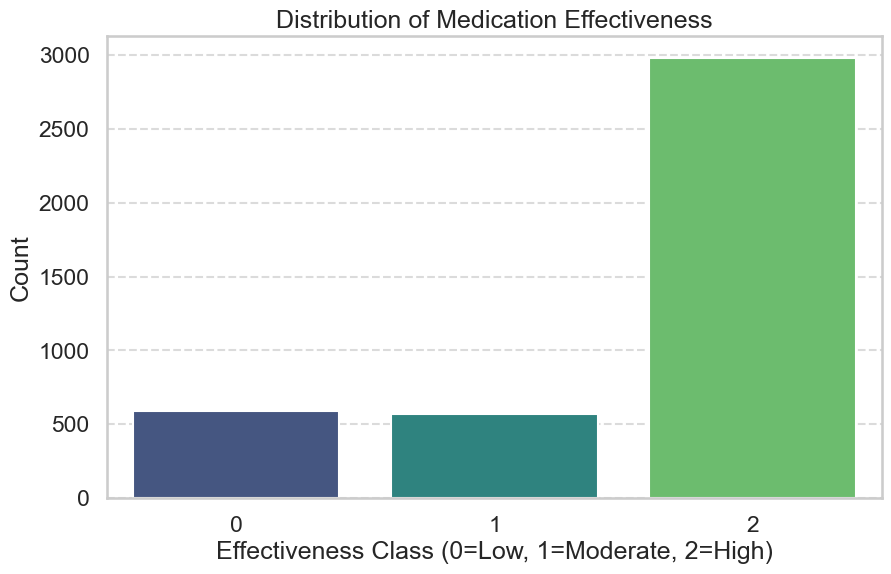

In [34]:
# Target Distribution Visualization
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Distribution of Medication Effectiveness')
plt.xlabel('Effectiveness Class (0=Low, 1=Moderate, 2=High)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

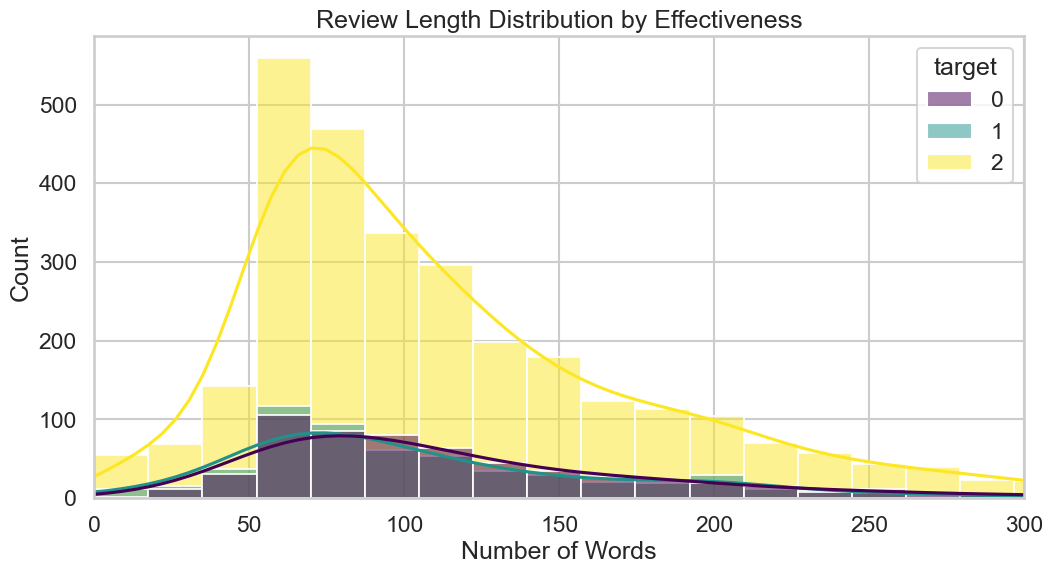

In [35]:
# Review Length Analysis
df['review_length'] = df['combined_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_length', hue='target', kde=True, bins=50, palette='viridis')
plt.title('Review Length Distribution by Effectiveness')
plt.xlabel('Number of Words')
plt.xlim(0, 300)  # Limiting x-axis to focus on the bulk of the data
plt.show()

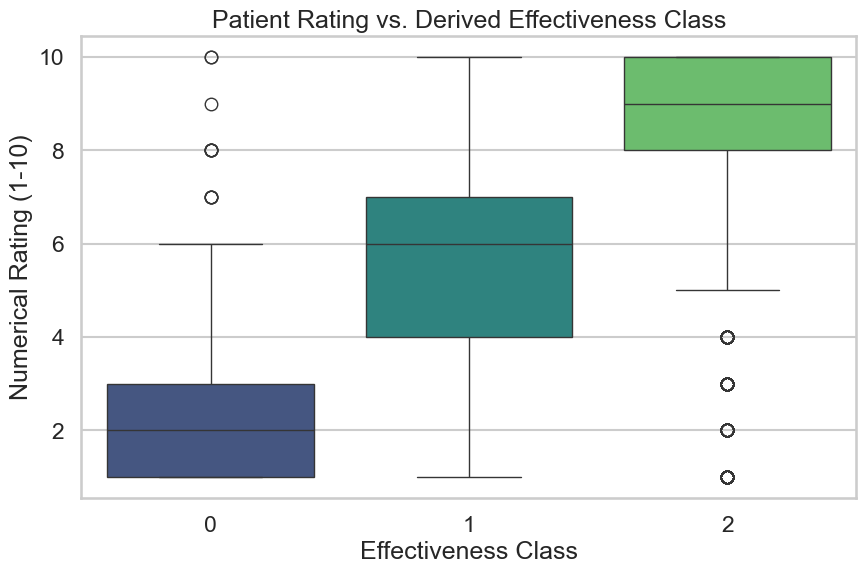

In [36]:
# Rating vs Effectiveness Correlation
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='rating', data=df, palette='viridis')
plt.title('Patient Rating vs. Derived Effectiveness Class')
plt.xlabel('Effectiveness Class')
plt.ylabel('Numerical Rating (1-10)')
plt.show()

## 4. Feature Engineering

We extract both semantic (text) and statistical features to feed into the LightGBM model.

1.  **TF-IDF Vectors**: Capturing word importance.
2.  **Sentiment Scores**: VADER compound score to capture emotional tone.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure VADER lexicon is downloaded
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# 1. TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    sublinear_tf=True
)

# 2. Sentiment Analysis
try:
    sia = SentimentIntensityAnalyzer()
except (LookupError, OSError):
    print("Warning: VADER lexicon not found even after download attempt. Installing...")
    nltk.download('vader_lexicon')
    sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

print("Generating Sentiment Scores...")
df['sentiment'] = df['combined_text'].apply(get_sentiment_score)

print("Generating TF-IDF Matrix...")
X_text = tfidf.fit_transform(df['combined_text'])

Generating Sentiment Scores...
Generating TF-IDF Matrix...


## 5. Model Initialization Disclosure

**Start from Scratch**: We are training a LightGBM model from scratch using Random Initialization.
- **Pretrained Weights**: None used for the core classifier.
- **Architecture**: Gradient Boosting Decision Trees (GBDT).
- **Justification**: LightGBM is chosen for its efficiency with tabular/sparse data and interpretability compared to deep neural networks for this dataset size (approx. 4000 rows).

## 6. Model Development (LightGBM)

We train a Gradient Boosting Decision Tree (LightGBM) using the TF-IDF and metadata features. We use a stratified train-validation split to prevent data leakage.

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import hstack

# Prepare Feature Matrix
# Combine TF-IDF with numeric features (Rating, Sentiment, Review Length)
meta_features = df[['rating', 'sentiment', 'review_length']].values
X = hstack([X_text, meta_features])
y = df['target'].values

# Stratified Data Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Create LightGBM Datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Hyperparameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': SEED
}

# Train with Explicit Logging
print("Starting Training...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

# Save Model for Competition Requirement
model.save_model('model.txt')
print("Model saved to 'model.txt'.")

# Validation Evaluation
y_pred_prob = model.predict(X_val)
y_pred = [np.argmax(x) for x in y_pred_prob]

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Ineffective', 'Moderate', 'Effective']))

Starting Training...
Training until validation scores don't improve for 50 rounds
[50]	training's multi_logloss: 0.251055	valid_1's multi_logloss: 0.479007
[100]	training's multi_logloss: 0.124802	valid_1's multi_logloss: 0.481715
Early stopping, best iteration is:
[74]	training's multi_logloss: 0.177577	valid_1's multi_logloss: 0.474865
Model saved to 'model.txt'.

Classification Report:
              precision    recall  f1-score   support

 Ineffective       0.64      0.74      0.69       119
    Moderate       0.44      0.24      0.31       114
   Effective       0.87      0.92      0.89       596

    accuracy                           0.80       829
   macro avg       0.65      0.63      0.63       829
weighted avg       0.78      0.80      0.78       829



### Evaluation Visualizations
Visualizing the Confusion Matrix to spot where the model is confident vs confused.

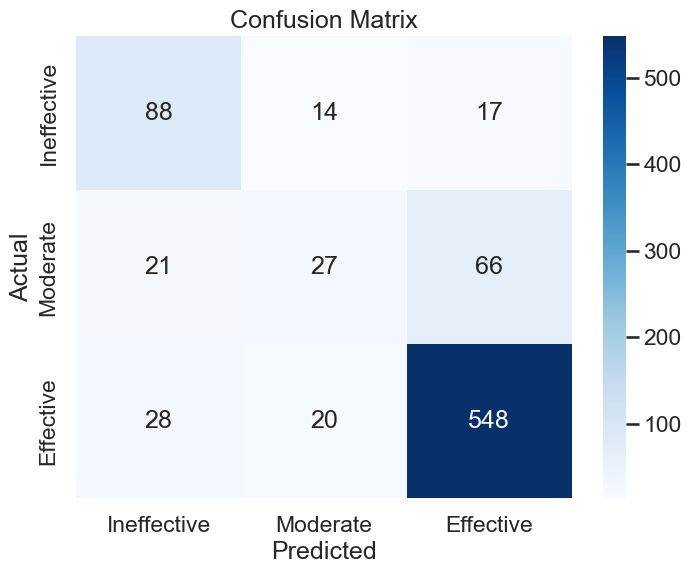

In [39]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ineffective', 'Moderate', 'Effective'], yticklabels=['Ineffective', 'Moderate', 'Effective'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 7. Agentic Decision-Support System

The core innovation of this project is the **Agentic Framework**. It goes beyond simple prediction to provide a verified, context-aware decision.

### Agent Components
1.  **Integrity Agent**: Checks for data quality issues (e.g., mismatched ratings).
2.  **Retrieval Agent**: Finds similar historical cases to provide context.
3.  **Verification Agent**: Assesses model confidence and stability.
4.  **Decision Agent**: Synthesizes all inputs into a final recommendation.

In [40]:
from sklearn.neighbors import NearestNeighbors

class MedFollowAgent:
    def __init__(self, model, tfidf_vectorizer, X_train_tfidf, train_df):
        self.model = model
        self.tfidf = tfidf_vectorizer
        self.X_train_tfidf = X_train_tfidf
        self.train_df = train_df.reset_index(drop=True)
        
        # Initialize Retrieval System (Nearest Neighbors)
        self.retriever = NearestNeighbors(n_neighbors=3, metric='cosine')
        self.retriever.fit(self.X_train_tfidf)

    def check_integrity(self, text, rating, prediction_class):
        """Stage 1: Integrity Checks"""
        flags = []
        
        # Rule 1: Very short reviews might be unreliable
        if len(str(text).split()) < 5:
            flags.append("Review too short")
        
        # Rule 2: Contradiction Check (High Rating / Low Effectiveness)
        # Rating is 1-10. Prediction 0 is Ineffective.
        if rating >= 8 and prediction_class == 0:
            flags.append("Contradiction: High Rating / Low Effectiveness")
        
        if rating <= 3 and prediction_class == 2:
            flags.append("Contradiction: Low Rating / High Effectiveness")
            
        return flags

    def retrieve_context(self, input_vector):
        """Stage 2: Retrieval"""
        distances, indices = self.retriever.kneighbors(input_vector)
        similar_cases = self.train_df.iloc[indices[0]][['condition', 'effectiveness', 'combined_text']]
        return similar_cases

    def make_decision(self, text, rating, review_length):
        """Full Pipeline Execution"""
        # 1. Feature Prep
        text_vec = self.tfidf.transform([text])
        sentiment = get_sentiment_score(text)
        # Meta features must match training order: rating, sentiment, review_length
        meta = np.array([[rating, sentiment, review_length]])
        combined_features = hstack([text_vec, meta])
        
        # 2. Prediction
        probs = self.model.predict(combined_features)[0]
        pred_class = np.argmax(probs)
        confidence = np.max(probs)
        
        # 3. Integrity Check
        integrity_flags = self.check_integrity(text, rating, pred_class)
        
        # 4. Retrieval
        context = self.retrieve_context(text_vec)
        
        # 5. Decision Generation
        decision = "Uncertain"
        rationale = []
        
        if integrity_flags:
            decision = "MANUAL REVIEW REQUIRED"
            rationale.append(f"Integrity Flags: {integrity_flags}")
        elif confidence < 0.6:
            decision = "MONITOR / CONSULT"
            rationale.append(f"Low model confidence ({confidence:.2f})")
        else:
            if pred_class == 2: # Effective
                decision = "CONTINUE MEDICATION"
                rationale.append("High confidence in Effectiveness")
            elif pred_class == 0: # Ineffective
                decision = "CONSIDER SWITCHING"
                rationale.append("High confidence in Ineffectiveness")
            else:
                decision = "MONITOR SYMPTOMS"
                rationale.append("Moderate effectiveness predicted")

        return {
            "Decision": decision,
            "Rationale": "; ".join(rationale),
            "Confidence": float(confidence),
            "Predicted_Class": int(pred_class),
            "Similar_Cases": context.to_dict('records')
        }

# Initialize Agent
# Use X_train via train_data or directly since we have it
# Fix: lightgbm.Dataset objects don't always expose .data with len()
# We will use X_train.shape[0] directly as X_train is available in local scope
agent = MedFollowAgent(model, tfidf, X_text[:X_train.shape[0]], df.iloc[:X_train.shape[0]])
print("Agent Initialized and Ready.")

Agent Initialized and Ready.


In [41]:
# Example of Agent in Action
sample_review = "The medicine worked great for my headache but made me slightly dizzy."
sample_rating = 8
result = agent.make_decision(sample_review, sample_rating, len(sample_review.split()))

print(f"Decision: {result['Decision']}")
print(f"Rationale: {result['Rationale']}")
print(f"Confidence: {result['Confidence']:.4f}")
print("\nReference Cases Retrieved:")
for i, case in enumerate(result['Similar_Cases'], 1):
    print(f"{i}. [{case['effectiveness']}] {case['condition']}: {case['combined_text'][:100]}...")

Decision: CONTINUE MEDICATION
Rationale: High confidence in Effectiveness
Confidence: 0.9738

Reference Cases Retrieved:
1. [Highly Effective] headache: headache stopped none great result...
2. [Ineffective] ear infection: not many. but it helped numb the pain and slightly make the redness fade away. it also helped me get...
3. [Highly Effective] migraine headaches: migraine headache would stop dizzy, palpitations i have taken both the shots and the pills (separate...


In [42]:
# Report Helper
print("=== SUMMARY FOR REPORT ===")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Total Data Points: {len(df)}")
print(f"Train-Val Ratio: 80-20")
print(f"Global Seed: {SEED}")

=== SUMMARY FOR REPORT ===
Accuracy: 0.7998
Total Data Points: 4143
Train-Val Ratio: 80-20
Global Seed: 42
